# 1. Extracción de rasgos de imágenes de fracturas en concreto con SVM

**Objetivo:** Extracción de rasgos globales de imágenes de fracturas.

Concrete surface cracks are major defect in civil structures. Building Inspection which is done for the evaluation of rigidity and tensile strength of the building. Crack detection plays a major role in the building inspection, finding the cracks and determining the building health.


https://www.kaggle.com/arunrk7/surface-crack-detection

**Información de las características**
The datasets contains images of various concrete surfaces with and without crack. The image data are divided into two as negative (without crack) and positive (with crack) in separate folder for image classification.


**Número de instancias:** 20000


# 2. Acceso a Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Importando librerías

In [2]:
pip install mahotas

     |████████████████████████████████| 5.7MB 6.6MB/s 


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import random
import mahotas

# 4. Exploración de los datos

In [4]:
path = r"/content/drive/MyDrive/Cracked"

In [5]:
clases=[d for d in os.listdir(path) if os.path.isdir(os.path.join(path,d))]
print(clases)

['Negative', 'Positive']


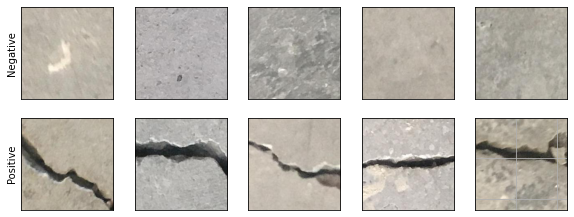

(227, 227, 3)


In [8]:
plt.figure(figsize=(20,20))
for i,folder in enumerate(clases):
    path_folder = os.path.join(path, folder)
    imgs_list =os.listdir(path_folder)
    random.shuffle(imgs_list)
    for j in range(5):
        img_path = os.path.join(path_folder,imgs_list[j])
        plt.subplot(10,10,i*10+j+1)
        img = plt.imread(img_path)
        plt.imshow(img)
        #plt.axis("off")
        plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, right=False,
                        labelbottom=False, labelleft=False)
        if j==0:
            plt.ylabel(folder)
plt.grid('off')
plt.show()
print(img.shape)

In [ ]:
fixed_size = (227, 227)
def count_labels(clases, path):
    n_img =[]
    for i, rock in enumerate(clases):
        pathi = os.path.join(path,rock)
        n_img.append(len(os.listdir(pathi)))
    #print(n_img)
    labels = []
    for i in range(len(clases)):
        labels.append([clases[i]]*n_img[i])
    ylabels = labels[0]
    for i in range(1,len(labels)):
        ylabels += labels[i]
    return ylabels, n_img

def histograma(ylabels, clases, title, color="goldenrod"):
    #histogramas de las categorias de las imágenes 
    plt.figure(figsize=(8,6))
    a = np.array(ylabels)
    plt.hist(a, bins=np.arange(-0.5,len(clases)+0.5,1.0), rwidth=0.7, color=color, ec=color)
    plt.title(title)
    plt.show()

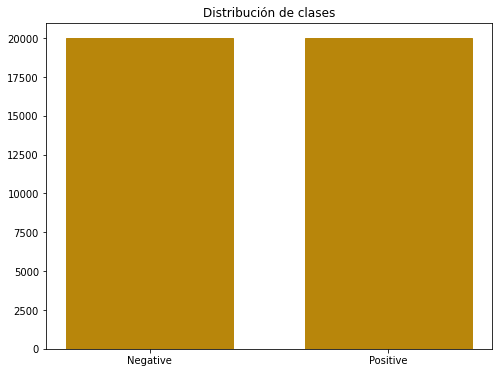

In [ ]:
ylabels, n_img = count_labels(clases, path)
histograma(ylabels, clases,"Distribución de clases", color="darkgoldenrod")

In [ ]:
n = np.sum(n_img)
print("Hay %s imágenes"%n)

Hay 40000 imágenes


# 5. Transformación de imágenes a formatos estructurado


#### a) Descriptores Globales

In [ ]:
# descriptor de rasgos: Momentos Hu 
def fd_hu_moments(image):
  # convertir imagen en escala de grises
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # calculo del vector de rasgos de momentos Hu
  feature = cv2.HuMoments(cv2.moments(image)).flatten()
  return feature

In [ ]:
# descriptor de rasgos: Haralick Texture
def fd_haralick(image):
  # convertir imagen en escala de grises
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # calculo del vector de rasgos de textura haralick
  haralick = mahotas.features.haralick(gray).mean(axis=0)
  return haralick

In [ ]:
# descriptor de rasgos: Histograma de color
def fd_histogram(image, mask=None, bins=8):
  # conversión de la imagen al espacio de color HSV
  image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  # calculo del histograma de color
  hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
  # normalización del histograma
  cv2.normalize(hist, hist)
  return hist.flatten()

#### b) Creación de dataframe

In [ ]:
cols=[]
ind=[]
for i in range(512):
    cols.append("histogram_%s"%i)
for i in range(13):
    cols.append("hal_%s"%i)
for i in range(7):
    cols.append("hum_%s"%i)
cols.append("label")
for i in range(n):
    ind.append(i)
df = pd.DataFrame(columns = cols,index=ind) 

In [ ]:
# ordenando las clases
clases.sort()

#### c) Extracción de rasgos por imagen

In [ ]:
def global_features(df,path,labels):
  ac=0
  for name in labels:
    # directorio de la clase
    dirc = os.path.join(path, name)
    # nombre de la clase actual
    current_label = name
    images = os.listdir(dirc)
    images.sort()
    # ciclo sobre cada imagen
    for image_name in images:
      # path de la imagen
      file = os.path.join(dirc,image_name)
      # lectura y redimensionar la imagen
      image = cv2.imread(file)
      image = cv2.resize(image, fixed_size)
      # Extraccion de rasgos globales
      fv_hu_moments = fd_hu_moments(image)
      fv_haralick   = fd_haralick(image)
      #fv_histogram  = fd_hog(image)
      fv_histogram  = fd_histogram(image)
      linea = np.hstack([fv_histogram, fv_haralick, fv_hu_moments, current_label])
      # agrega linea al dataframe vacío 
      df.iloc[ac] = linea
      if ac%500 == 0:
        print(ac)
      ac+=1
    print("Folder procesado: {}".format(current_label))
  print("Extracción de rasgos globales completa")


In [ ]:
global_features(df,path,clases)
new_path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.7 Máquinas de soporte vectorial'
df.to_csv(os.path.join(new_path,'Crack_detection.csv'), index=False)